# Telecom Data Analysis (Notebook)

This notebook performs an analysis using `telecom_data_large.csv`. It includes data cleaning, feature engineering, outlier handling, IsolationForest anomaly detection, and answers 10 analytical questions with inline plots.


In [1]:

# Setup: imports and configuration
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, sys, os
from pathlib import Path
%matplotlib inline
from google.colab import drive #To import file from drive
drive.mount('/content/drive')

DATA_PATH = Path("/content/drive/MyDrive/Colab Notebooks/telecom_data_dataset.csv")
OUT_DIR = Path("telecom_expert_notebook_outputs")
PLOTS_DIR = OUT_DIR / "plots"
OUT_DIR.mkdir(exist_ok=True)
PLOTS_DIR.mkdir(exist_ok=True)

# Try to import sklearn IsolationForest
SKLEARN_AVAILABLE = True
try:
    from sklearn.ensemble import IsolationForest
except Exception:
    SKLEARN_AVAILABLE = False
    print("scikit-learn not installed. IsolationForest will be skipped. To enable, install scikit-learn with 'pip install scikit-learn'.")

def save_df(df, name):
    p = OUT_DIR / f"{name}.csv"
    df.to_csv(p, index=False)
    print("Saved:", p)
    return p

def save_fig(fig, name):
    p = PLOTS_DIR / f"{name}.png"
    fig.savefig(p, bbox_inches='tight')
    print("Saved plot:", p)
    return p


Mounted at /content/drive


In [2]:

# Load dataset
if not Path().resolve().joinpath(DATA_PATH).exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please upload the CSV to that path before running this notebook.")

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
print("Loaded dataset with shape:", df.shape)
df.head()


Loaded dataset with shape: (5200, 20)


,record_id,region,country,date,network_type,operator,device_type,signal_strength_dbm,latency_ms,throughput_mbps,data_usage_gb,call_drop_rate,packet_loss_percent,jitter_ms,download_speed_mbps,upload_speed_mbps,num_connected_users,network_availability_percent,temperature_celsius,weather_condition
0,R00001,West,Italy,2023-01-01 00:00:00,5G,Vodafone,Router,-57,101,205.17,9.77,1.94,0.14,12.65,120.48,6.60,849,97.83,-3.0,Rainy
1,R00002,Central,Italy,2023-01-01 01:00:00,4G,Deutsche Telekom,Smartphone,-53,29,102.37,29.68,1.25,0.12,17.92,148.36,7.01,621,98.90,1.8,Rainy
2,R00003,East,Germany,2023-01-01 02:00:00,5G,Orange,Tablet,-79,42,16.93,6.26,1.03,0.87,11.52,65.69,8.48,910,96.45,11.6,Clear
3,R00004,Central,Netherlands,2023-01-01 03:00:00,4G,Vodafone,Tablet,-72,37,142.79,24.27,1.77,0.63,12.16,111.56,103.85,412,95.84,26.1,Cloudy
4,R00005,Central,Italy,2023-01-01 04:00:00,4G,Deutsche Telekom,Tablet,-67,77,173.31,3.33,0.84,0.46,8.10,219.78,21.15,612,97.25,4.3,Rainy


In [3]:

# Data cleaning
before = df.shape[0]
df = df.drop_duplicates()
print("Dropped duplicates:", before - df.shape[0])

# Parse date
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Fill missing values
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in num_cols:
    if df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    if df[c].isna().any():
        m = df[c].mode()
        df[c].fillna(m[0] if not m.empty else 'Unknown', inplace=True)

# Feature engineering
if 'date' in df.columns:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour

if 'signal_strength_dbm' in df.columns:
    mn, mx = df['signal_strength_dbm'].min(), df['signal_strength_dbm'].max()
    df['signal_quality'] = ((df['signal_strength_dbm'] - mn)/(mx-mn) * 100).round(2) if mx!=mn else 50.0

if set(['throughput_mbps','latency_ms','network_availability_percent','call_drop_rate']).issubset(df.columns):
    df['latency_ms'] = df['latency_ms'].replace(0, np.nan).fillna(df['latency_ms'].median())
    df['efficiency_score'] = (df['throughput_mbps'] / df['latency_ms']) * (df['network_availability_percent']/100) * (1 - df['call_drop_rate']/100)
    df['efficiency_score'] = df['efficiency_score'].round(4)

# Outlier capping
def cap_iqr(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return s.clip(lower=q1-k*iqr, upper=q3+k*iqr)

for c in ['throughput_mbps','latency_ms','data_usage_gb','download_speed_mbps','upload_speed_mbps','packet_loss_percent','jitter_ms']:
    if c in df.columns:
        df[c + '_capped'] = cap_iqr(df[c])

# Anomaly detection (z-score)
anomaly_cols = [c for c in ['latency_ms','packet_loss_percent','call_drop_rate','throughput_mbps'] if c in df.columns]
if len(anomaly_cols) >= 2:
    z = df[anomaly_cols].apply(lambda x: (x - x.mean())/x.std(ddof=0))
    df['anomaly_z_any'] = z.abs().gt(3).any(axis=1)
else:
    df['anomaly_z_any'] = False

# IsolationForest optional
if SKLEARN_AVAILABLE and len(anomaly_cols) >= 2:
    model = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
    df['anomaly_iforest'] = model.fit_predict(df[anomaly_cols].fillna(0)) == -1
else:
    df['anomaly_iforest'] = False

print("Cleaning and feature engineering complete.")
df.head()


Dropped duplicates: 0
Cleaning and feature engineering complete.


,record_id,region,country,date,network_type,operator,device_type,signal_strength_dbm,latency_ms,throughput_mbps,...,efficiency_score,throughput_mbps_capped,latency_ms_capped,data_usage_gb_capped,download_speed_mbps_capped,upload_speed_mbps_capped,packet_loss_percent_capped,jitter_ms_capped,anomaly_z_any,anomaly_iforest
0,R00001,West,Italy,2023-01-01 00:00:00,5G,Vodafone,Router,-57,101,205.17,...,1.9488,205.17,101,9.77,120.48,6.60,0.14,12.65,False,False
1,R00002,Central,Italy,2023-01-01 01:00:00,4G,Deutsche Telekom,Smartphone,-53,29,102.37,...,3.4475,102.37,29,29.68,148.36,7.01,0.12,17.92,False,False
2,R00003,East,Germany,2023-01-01 02:00:00,5G,Orange,Tablet,-79,42,16.93,...,0.3848,16.93,42,6.26,65.69,8.48,0.87,11.52,False,False
3,R00004,Central,Netherlands,2023-01-01 03:00:00,4G,Vodafone,Tablet,-72,37,142.79,...,3.6332,142.79,37,24.27,111.56,103.85,0.63,12.16,False,False
4,R00005,Central,Italy,2023-01-01 04:00:00,4G,Deutsche Telekom,Tablet,-67,77,173.31,...,2.1705,173.31,77,3.33,219.78,21.15,0.46,8.10,False,False


### Q1: Average signal strength by region and network type

In [4]:

if set(['region','network_type','signal_strength_dbm']).issubset(df.columns):
    q1 = df.groupby(['region','network_type'])[['signal_strength_dbm','signal_quality']].mean().reset_index()
    display(q1)
    save_df(q1, 'Q1_avg_signal_by_region_network')
else:
    print("Q1: missing columns")


,region,network_type,signal_strength_dbm,signal_quality
0,Central,4G,-72.986692,50.030228
1,Central,5G,-73.220370,49.499296
2,East,4G,-72.616896,50.870806
3,East,5G,-73.433663,49.014515
4,North,4G,-72.981633,50.041714
5,North,5G,-73.363799,49.173208
6,South,4G,-72.717647,50.641804
7,South,5G,-73.414000,49.059180
8,West,4G,-72.532544,51.062682
9,West,5G,-72.805405,50.442306


Saved: telecom_expert_notebook_outputs/Q1_avg_signal_by_region_network.csv


### Q2: Operator with highest average throughput

,operator,throughput_mbps
3,Telecom Italia,134.641342
1,O2,133.483100
2,Orange,132.768966
0,Deutsche Telekom,131.279824
4,Vodafone,127.881816


Saved: telecom_expert_notebook_outputs/Q2_operator_avg_throughput.csv
Saved plot: telecom_expert_notebook_outputs/plots/Q2_operator_avg_throughput.png


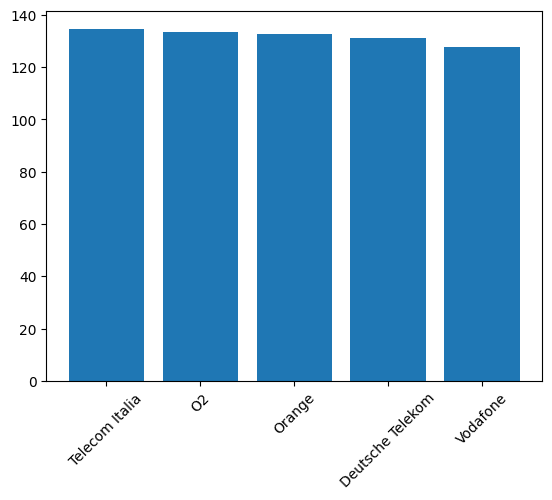

In [5]:

if 'operator' in df.columns and 'throughput_mbps' in df.columns:
    q2 = df.groupby('operator')['throughput_mbps'].mean().reset_index().sort_values('throughput_mbps', ascending=False)
    display(q2)
    save_df(q2, 'Q2_operator_avg_throughput')
    fig, ax = plt.subplots()
    ax.bar(q2['operator'], q2['throughput_mbps'])
    plt.xticks(rotation=45)
    save_fig(fig, 'Q2_operator_avg_throughput')
else:
    print("Q2: missing columns")


### Q3: Top 5 countries by total data usage

In [6]:

if 'country' in df.columns and 'data_usage_gb' in df.columns:
    q3 = df.groupby('country')['data_usage_gb'].sum().reset_index().sort_values('data_usage_gb', ascending=False).head(5)
    display(q3)
    save_df(q3, 'Q3_top5_countries_data_usage')
else:
    print("Q3: missing columns")


,country,data_usage_gb
0,France,16561.71
1,Germany,15936.84
3,Netherlands,15731.98
2,Italy,15247.83
4,Spain,14706.14


Saved: telecom_expert_notebook_outputs/Q3_top5_countries_data_usage.csv


### Q4: Latency difference (4G vs 5G) with t-test

In [7]:

if 'network_type' in df.columns and 'latency_ms' in df.columns:
    q4 = df.groupby('network_type')['latency_ms'].agg(['mean','median','std','count']).reset_index()
    display(q4)
    save_df(q4, 'Q4_latency_by_network_type')
    if set(['4G','5G']).issubset(df['network_type'].unique()):
        from scipy.stats import ttest_ind
        lat4 = df[df['network_type']=='4G']['latency_ms'].dropna()
        lat5 = df[df['network_type']=='5G']['latency_ms'].dropna()
        tstat, pval = ttest_ind(lat4, lat5, equal_var=False)
        print('t-stat', tstat, 'p-value', pval)
        with open(Path('telecom_expert_notebook_outputs')/'Q4_latency_ttest.json','w') as f:
            json.dump({'tstat': float(tstat), 'pvalue': float(pval)}, f)
else:
    print("Q4: missing columns")


,network_type,mean,median,std,count
0,4G,69.531865,69.5,28.771713,2542
1,5G,70.616253,71.0,28.986185,2658


Saved: telecom_expert_notebook_outputs/Q4_latency_by_network_type.csv
t-stat -1.3536299359140984 p-value 0.17591340760226468


### Q5: Hour with highest avg data usage

,hour,data_usage_gb
3,3,16.477327
18,18,15.888981
10,10,15.881521
21,21,15.739120
13,13,15.497558
4,4,15.421982
6,6,15.398295
22,22,15.341944
14,14,15.208111
12,12,15.097650


Saved: telecom_expert_notebook_outputs/Q5_hourly_avg_data_usage.csv
Saved plot: telecom_expert_notebook_outputs/plots/Q5_hourly_avg_data_usage.png


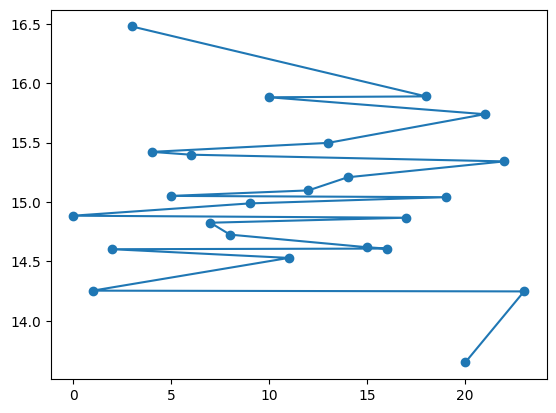

In [8]:

if 'data_usage_gb' in df.columns and 'hour' in df.columns:
    q5 = df.groupby('hour')['data_usage_gb'].mean().reset_index().sort_values('data_usage_gb', ascending=False)
    display(q5.head(10))
    save_df(q5, 'Q5_hourly_avg_data_usage')
    fig, ax = plt.subplots()
    ax.plot(q5['hour'], q5['data_usage_gb'], marker='o')
    save_fig(fig, 'Q5_hourly_avg_data_usage')
else:
    print("Q5: missing columns")


### Q6: Region with lowest call drop rate

In [9]:

if 'region' in df.columns and 'call_drop_rate' in df.columns:
    q6 = df.groupby('region')['call_drop_rate'].mean().reset_index().sort_values('call_drop_rate', ascending=True)
    display(q6)
    save_df(q6, 'Q6_region_lowest_call_drop')
else:
    print("Q6: missing columns")


,region,call_drop_rate
2,North,0.967338
3,South,0.981238
0,Central,0.993386
1,East,1.013836
4,West,1.019068


Saved: telecom_expert_notebook_outputs/Q6_region_lowest_call_drop.csv


### Q7: Weather impact on throughput

,weather_condition,mean,median,count
2,Rainy,135.552954,140.475,1266
3,Stormy,132.098861,133.815,1282
0,Clear,130.678824,131.760,1352
1,Cloudy,129.823508,128.940,1300


Saved: telecom_expert_notebook_outputs/Q7_throughput_by_weather.csv
Saved plot: telecom_expert_notebook_outputs/plots/Q7_throughput_by_weather.png


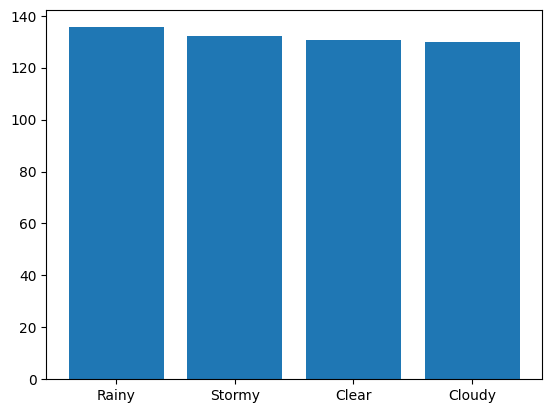

In [10]:

if 'weather_condition' in df.columns and 'throughput_mbps' in df.columns:
    q7 = df.groupby('weather_condition')['throughput_mbps'].agg(['mean','median','count']).reset_index().sort_values('mean', ascending=False)
    display(q7)
    save_df(q7, 'Q7_throughput_by_weather')
    fig, ax = plt.subplots()
    ax.bar(q7['weather_condition'], q7['mean'])
    save_fig(fig, 'Q7_throughput_by_weather')
else:
    print("Q7: missing columns")


### Q8: Device type with highest average data usage

In [11]:

if 'device_type' in df.columns and 'data_usage_gb' in df.columns:
    q8 = df.groupby('device_type')['data_usage_gb'].mean().reset_index().sort_values('data_usage_gb', ascending=False)
    display(q8)
    save_df(q8, 'Q8_device_avg_data_usage')
else:
    print("Q8: missing columns")


,device_type,data_usage_gb
1,Smartphone,15.135138
2,Tablet,15.003030
0,Router,14.967280


Saved: telecom_expert_notebook_outputs/Q8_device_avg_data_usage.csv


### Q9: Correlation between signal strength and throughput

In [12]:

if 'throughput_mbps' in df.columns and ('signal_quality' in df.columns or 'signal_strength_dbm' in df.columns):
    x = df['signal_quality'] if 'signal_quality' in df.columns else df['signal_strength_dbm']
    y = df['throughput_mbps']
    corr = x.corr(y)
    print('Pearson correlation:', corr)
    with open(Path('telecom_expert_notebook_outputs')/'Q9_signal_throughput_corr.json','w') as f:
        json.dump({'correlation': float(corr)}, f)
else:
    print("Q9: missing columns")


Pearson correlation: -0.001485733380351908


### Q10: Top 10 high-performance cells by efficiency_score

In [13]:

if 'efficiency_score' in df.columns:
    q10 = df.sort_values('efficiency_score', ascending=False).head(10)[['record_id','region','operator','throughput_mbps','latency_ms','network_availability_percent','call_drop_rate','efficiency_score']]
    display(q10)
    save_df(q10, 'Q10_top10_high_performance_cells')
else:
    print("Q10: missing columns")


,record_id,region,operator,throughput_mbps,latency_ms,network_availability_percent,call_drop_rate,efficiency_score
1819,R01820,South,Telecom Italia,246.07,20,99.52,1.70,12.0363
4267,R04268,South,O2,248.17,21,99.09,0.00,11.7101
4856,R04857,South,O2,249.58,21,98.91,0.60,11.6847
3940,R03941,East,Telecom Italia,235.83,20,96.78,1.94,11.1904
3396,R03397,Central,Telecom Italia,221.54,20,98.52,0.41,10.8683
2255,R02256,West,O2,242.05,22,98.75,0.20,10.8430
2243,R02244,Central,Telecom Italia,221.24,20,96.40,0.02,10.6616
1816,R01817,West,O2,249.50,23,98.78,0.51,10.6608
3388,R03389,North,Orange,219.25,20,97.14,0.41,10.6053
1834,R01835,North,Vodafone,240.77,22,98.03,1.24,10.5955


Saved: telecom_expert_notebook_outputs/Q10_top10_high_performance_cells.csv


## Conclusions & Next Steps

In [14]:

# Save cleaned and correlation outputs
df.to_csv(Path('telecom_expert_notebook_outputs')/'telecom_data_cleaned_notebook.csv', index=False)
df.select_dtypes(include=[np.number]).corr().to_csv(Path('telecom_expert_notebook_outputs')/'telecom_numeric_correlation_notebook.csv')
print("Saved cleaned data and correlation matrix.")


Saved cleaned data and correlation matrix.
